Calculated σ^2: 1.4343268712412492e-16
Adjusted As: 4687913288678145.0


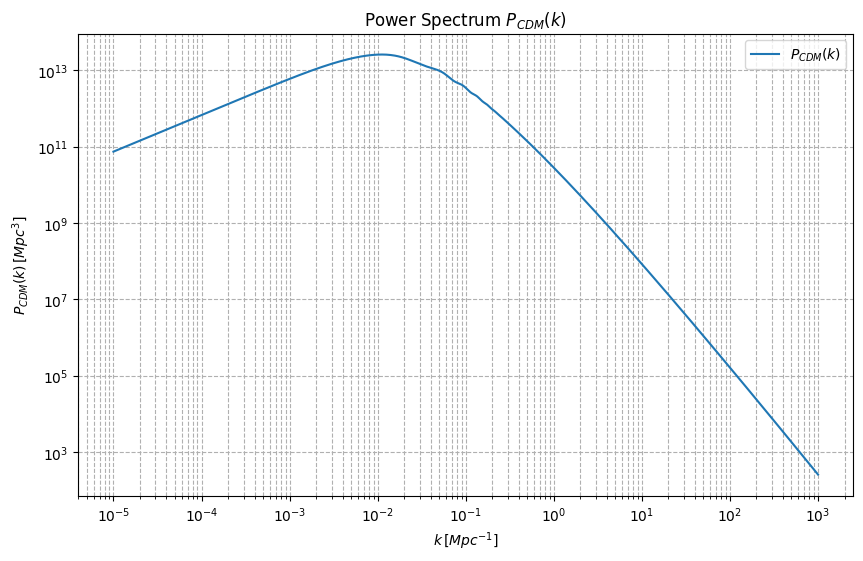

In [2]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad
import matplotlib.pyplot as plt


k, T_k = np.loadtxt('transfer-function.txt', usecols=(0, 1), unpack=True)


ns = 0.96
R = 8 * 0.6774  # Mpc
sigma8_observed = 0.82


T_k_interpolated = interp1d(k, T_k, kind='cubic', bounds_error=False, fill_value="extrapolate")


def W(kR):
    return 3 * (np.sin(kR) - kR * np.cos(kR)) / (kR**3)


def integrand(k, R, As=1):
    return (4 * np.pi * k**2) / (2 * np.pi)**3 * As * (k**ns) * T_k_interpolated(k)**2 * W(k*R)**2


sigma2_calculated, _ = quad(integrand, 1e-5, 1e5, args=(R, 1))
print(f'Calculated σ^2: {sigma2_calculated}')


As_adjusted = sigma8_observed**2 / sigma2_calculated
print(f'Adjusted As: {As_adjusted}')


def P_CDM(k, As=As_adjusted):
    return As * (k**ns) * T_k_interpolated(k)**2


k_plot = np.logspace(-5, 3, 1000)


P_CDM_plot = P_CDM(k_plot, As_adjusted)


plt.figure(figsize=(10, 6))
plt.loglog(k_plot, P_CDM_plot, label=r'$P_{CDM}(k)$')
plt.xlabel(r'$k \, [Mpc^{-1}]$')
plt.ylabel(r'$P_{CDM}(k) \, [Mpc^3]$')
plt.title(r'Power Spectrum $P_{CDM}(k)$')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


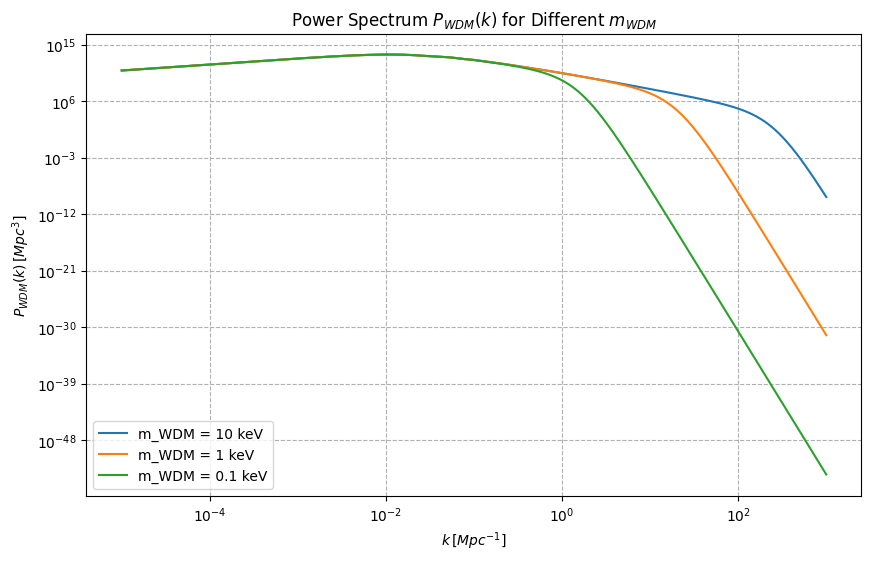

In [11]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad
import matplotlib.pyplot as plt


k, T_k = np.loadtxt('transfer-function.txt', usecols=(0, 1), unpack=True)


ns = 0.96
R = 8 * 0.6774  
sigma8_observed = 0.82
Om_WDM = 0.32
h = 0.6774
m_WDM_values = [10, 1, 0.1]  # keV

T_k_interpolated = interp1d(k, T_k, kind='cubic', bounds_error=False, fill_value="extrapolate")


def W(kR):
    return 3 * (np.sin(kR) - kR * np.cos(kR)) / (kR**3)


def TWDM(k, m_WDM):
    alpha = 0.049 * (m_WDM / 1)**-1.11 * (Om_WDM / 0.25)**0.11 * (h / 0.7)**1.22
    mu = 1.12
    return (1 + (alpha * k)**(2 * mu))**(-5.0 / mu)


def integrand(k, R, As, m_WDM=0):  
    if m_WDM == 0:  
        return (4 * np.pi * k**2) / (2 * np.pi)**3 * As * (k**ns) * T_k_interpolated(k)**2 * W(k*R)**2
    else:  
        return (4 * np.pi * k**2) / (2 * np.pi)**3 * As * (k**ns) * T_k_interpolated(k)**2 * TWDM(k, m_WDM)**2 * W(k*R)**2


sigma2_CDM_initial, _ = quad(integrand, 1e-5, 1e5, args=(R, 1))
As_adjusted = sigma8_observed**2 / sigma2_CDM_initial


plt.figure(figsize=(10, 6))


for m_WDM in m_WDM_values:
    k_plot = np.logspace(-5, 3, 1000)
    P_WDM_plot = As_adjusted * (k_plot**ns) * T_k_interpolated(k_plot)**2 * TWDM(k_plot, m_WDM)**2
    plt.loglog(k_plot, P_WDM_plot, label=f'm_WDM = {m_WDM} keV')

plt.xlabel(r'$k \, [Mpc^{-1}]$')
plt.ylabel(r'$P_{WDM}(k) \, [Mpc^3]$')
plt.title(r'Power Spectrum $P_{WDM}(k)$ for Different $m_{WDM}$')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


C:\Users\黄\LOCALS~1\Temp\ipykernel_18844\907616434.py:58: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(integrand, 5, 30)


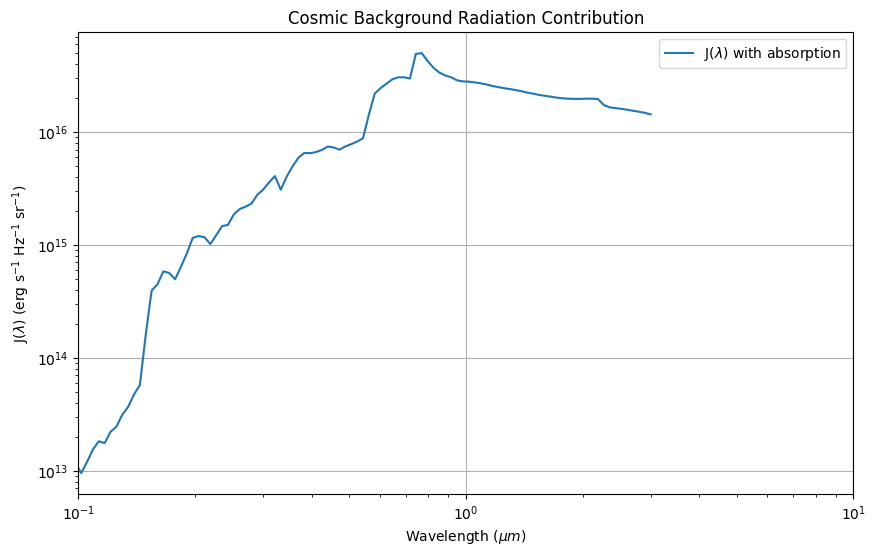

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline, interp1d
from scipy.integrate import quad, cumtrapz
from scipy.constants import parsec, c
import matplotlib.pyplot as plt

# 加载数据
data_dn_dM = np.loadtxt("dn_dM.txt", skiprows=1)
data_SED = np.loadtxt("SED.txt", skiprows=1)

# 参数
H0 = 67.72  
Omega_m = 0.32
Omega_Lambda = 0.68
Omega_b = 0.048
f_star = 0.1
pc_to_m = parsec * 1e6
Mpc_to_m = pc_to_m * 1e6
rho_c = 2.7752e11  
rho_m = rho_c * Omega_m  

# dn/dM 插值
z_unique = np.unique(data_dn_dM[:, 0])
M_unique = np.unique(data_dn_dM[:, 1])
dn_dM_grid = data_dn_dM[:, 2].reshape(len(z_unique), len(M_unique))
interp_dn_dM = RectBivariateSpline(z_unique, np.log10(M_unique), dn_dM_grid) #M太大了取个log吧

# SED 插值
interp_sed = interp1d(data_SED[:, 0], data_SED[:, 1], kind='cubic', bounds_error=False, fill_value="extrapolate")

# 计算 f_coll
def f_coll(z):
    M_min = 2.8e9 * (1 + z)**(-3/2)  
    integral, _ = quad(lambda M: interp_dn_dM(z, np.log10(M))[0, 0] / rho_m, M_min, 1e16)
    return integral

z_values = np.linspace(5, 30, 100)
f_coll_values = np.array([f_coll(z) for z in z_values])

# 计算 d f_coll / dz
df_coll_dz = np.gradient(f_coll_values, z_values)

# 计算 SFRD
def dz_dt(z, H0=H0, Omega_m=Omega_m, Omega_Lambda=Omega_Lambda):
    return - (1 + z) / (H0 * np.sqrt(Omega_m * (1 + z)**3 + Omega_Lambda)) * 3.24e-20  

sfrd = f_star * Omega_b / Omega_m * rho_m * df_coll_dz / dz_dt(z_values)

# 计算 J(nu)
def J_nu(nu):
    def integrand(z):
        nu_prime = nu * (1 + z)
        sfrd_z = np.interp(z, z_values, sfrd)
        sed_nu_prime = interp_sed(nu_prime)
        return sfrd_z * sed_nu_prime / ((1 + z) * H0 * np.sqrt(Omega_m * (1 + z)**3 + Omega_Lambda)) * 3.24e-20  # Convert H0 to s^-1

    integral, _ = quad(integrand, 5, 30)
    return integral / (4 * np.pi)


# 转换频率到波长
nu_values = np.logspace(14, 15.5, 100)  
lambda_values = c / nu_values 
lambda_values_micron = lambda_values * 1e6  


J_values = np.array([J_nu(nu) for nu in nu_values])

# huatu
plt.figure(figsize=(10, 6))
plt.loglog(lambda_values_micron, J_values, label='J($\\lambda$) with absorption')
plt.xlim(0.1, 10)  
plt.xlabel('Wavelength ($\\mu m$)')
plt.ylabel('J($\\lambda$) (erg s$^{-1}$ Hz$^{-1}$ sr$^{-1}$)')
plt.title('Cosmic Background Radiation Contribution')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_43/796127553.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(integrand, 5, 30)


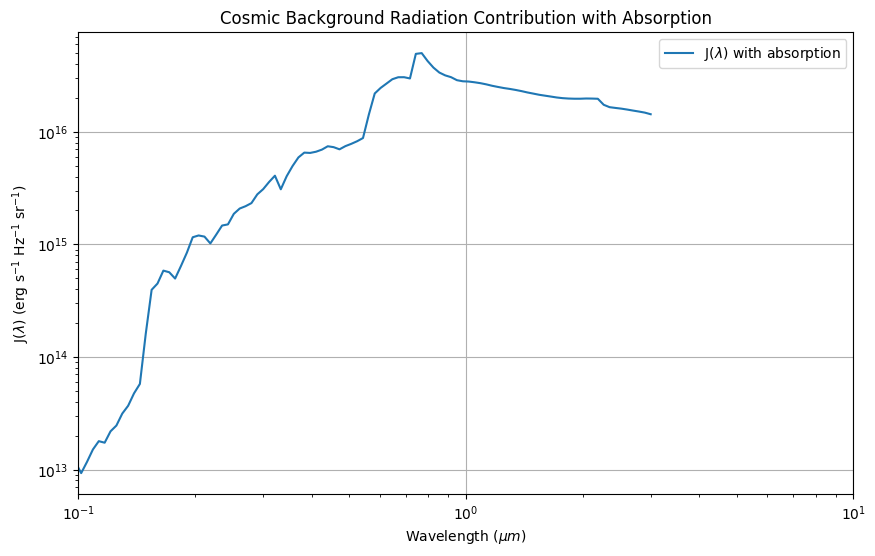

In [19]:
# 计算考虑吸收的 J(nu)
nu_alpha = 2.47e15  

def J_nu_absorbed(nu):
    def integrand(z):
        if z > 6 and nu > nu_alpha:
            return 0  
        nu_prime = nu * (1 + z)
        sfrd_z = np.interp(z, z_values, sfrd)
        sed_nu_prime = interp_sed(nu_prime)
        return sfrd_z * sed_nu_prime / ((1 + z) * H0 * np.sqrt(Omega_m * (1 + z)**3 + Omega_Lambda)) * 3.24e-20

    integral, _ = quad(integrand, 5, 30)
    return integral / (4 * np.pi)


lambda_values = c / nu_values  
lambda_values_micron = lambda_values * 1e6  

J_values_absorbed = np.array([J_nu_absorbed(nu) for nu in nu_values])

# plt
plt.figure(figsize=(10, 6))
plt.loglog(lambda_values_micron, J_values_absorbed, label='J($\\lambda$) with absorption')
plt.xlim(0.1, 10)  
plt.xlabel('Wavelength ($\\mu m$)')
plt.ylabel('J($\\lambda$) (erg s$^{-1}$ Hz$^{-1}$ sr$^{-1}$)')
plt.title('Cosmic Background Radiation Contribution with Absorption')
plt.legend()
plt.grid(True)
plt.show()


### 利用插值的两个有无Absorption的结果图几乎一致
##### 如果用拟合的话会有所差异,下面的结果图dn/dm用的是pytorch的10000轮次初步拟合结果，我们会发现低波长的影响

```python
#dn/dm的pytorch拟合代码
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 检查CUDA是否可用，并设置device变量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# 加载数据
data = np.loadtxt('dn_dM.txt', skiprows=1)
x_data = data[:, 0:2]  # x, y
# 对y值取对数
x_data[:, 1] = np.log(x_data[:, 1])
z_data = data[:, 2]    # z

# 转换为torch tensors并移至指定设备
x_train = torch.tensor(x_data, dtype=torch.float32).to(device)
z_train = torch.tensor(z_data, dtype=torch.float32).view(-1, 1).to(device)

# 定义网络结构
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # 输入层到隐藏层
        self.fc2 = nn.Linear(64, 64) # 隐藏层
        self.fc3 = nn.Linear(64, 1)  # 隐藏层到输出层

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# 创建模型并移至指定设备
model = Net().to(device)

# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(x_train)
    loss = criterion(output, z_train)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')
        
        


model.eval()

# 在CPU上绘制结果（绘图库通常不支持直接在GPU上绘图）
x_data_cpu = x_train.to('cpu').numpy()
z_data_cpu = z_train.to('cpu').numpy()
z_pred_cpu = model(x_train).to('cpu').detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data_cpu[:, 0], x_data_cpu[:, 1], z_data_cpu, color='r', label='Original Data')
ax.scatter(x_data_cpu[:, 0], x_data_cpu[:, 1], z_pred_cpu, color='g', label='Fitted Data')
ax.set_xlabel('X Label(z)')
ax.set_ylabel('Y Label (log(m))')
ax.set_zlabel('Z Label(dn/dm)')
ax.legend()
plt.show()

```

![img](./2-1-pytorch.png)
![img](./2-2-pytorch.png)

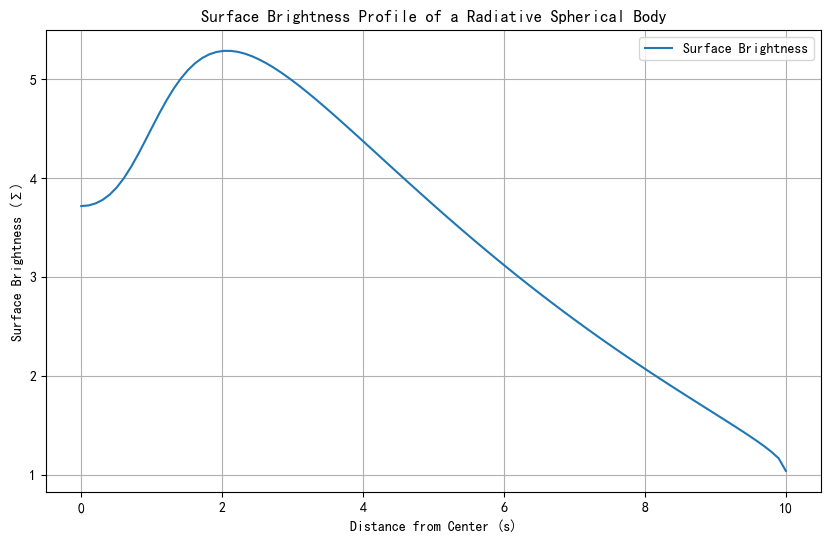

In [32]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

# 常量定义
R = 10  # 天体半径
r1 = 5  # 发射率衰减距离
r2 = 1  # 密度衰减距离
k0 = 2.5  # 吸收系数

# 发射率函数
def epsilon(r):
    return np.exp(-r / r1)

# 密度函数
def rho(r):
    return 1 / (1 + (r / r2)**2)

# 光深计算函数
def tau(x_prime, s, theta):
    def integrand(x_double_prime):
        r_double_prime = np.sqrt(R**2 + x_double_prime**2 - 2 * R * x_double_prime * np.cos(theta))
        return k0 * rho(r_double_prime)**2
    return quad(integrand, 0, x_prime)[0]

# 面亮度计算函数
def surface_brightness(s):
    theta = np.arcsin(s / R)
    
    def integrand(x_prime):
        r_prime = np.sqrt(R**2 + x_prime**2 - 2 * R * x_prime * np.cos(theta))
        return epsilon(r_prime) * np.exp(-tau(x_prime, s, theta))
    
    return quad(integrand, 0, np.sqrt(2 * R**2 - s**2))[0]

# 计算和绘制面亮度图像
s_values = np.linspace(0, R, 100)
sigma_values = [surface_brightness(s) for s in s_values]

plt.figure(figsize=(10, 6))
plt.plot(s_values, sigma_values, label="Surface Brightness")
plt.xlabel('Distance from Center (s)')
plt.ylabel('Surface Brightness (Σ)')
plt.title('Surface Brightness Profile of a Radiative Spherical Body')
plt.legend()
plt.grid(True)
plt.show()
